In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as tfs
import torchvision
from torch.utils.data import DataLoader

from dataset import DEFAULT_PATH, MDFADataset, SirstDataset
from model import CAN, Discriminator
from engine import train_one_epoch, evaluate
import utils

In [18]:
model1_path = 'checkpoints/G1_29.pt'
model2_path = 'checkpoints/G2_29.pt'
    
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model1 = torch.load(model1_path)
model2 = torch.load(model2_path)

model1 = model1.module
model2 = model2.module

model1 = model1.to(device)
model2 = model2.to(device)

In [39]:
test_dataset = 'Sirst'
transforms = tfs.Compose([
    tfs.Grayscale(num_output_channels=1),
    tfs.ToTensor(),
    tfs.Normalize(mean=0.5, std=0.5)
])
target_transforms = tfs.Compose([
    tfs.Grayscale(num_output_channels=1),
    tfs.ToTensor()
])

train_dataset = MDFADataset(root=DEFAULT_PATH['mdfa_train'], split='train', transform=transforms, target_transform=target_transforms)

if test_dataset == 'MDFA':
    root = DEFAULT_PATH['mdfa_test']
    test_dataset = MDFADataset(root=root, split='test', transform=transforms, target_transform=target_transforms)
elif test_dataset == 'Sirst':
    root = DEFAULT_PATH['sirst']
    test_dataset = SirstDataset(root=root, transform=transforms, target_transform=target_transforms)

testloader = DataLoader(test_dataset, batch_size=5, shuffle=False)
trainloader = DataLoader(train_dataset, batch_size=10, shuffle=False)

In [43]:
model1.eval()
model2.eval()
testloader = iter(testloader)

In [49]:
with torch.no_grad():
    
    data = next(testloader)

    img, target = data
    batchsize = img.size(0)

    img = img.to(device)
    target = target.to(device)

    output1 = model1(img)
    output2 = model2(img)
    torch.cuda.empty_cache()

In [22]:
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 8.0) # 显示大小

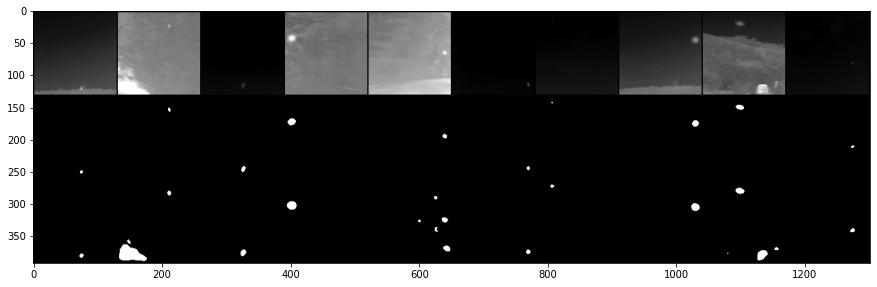

In [52]:
output = (output1 + output2) / 2 
output = torch.where(output > 0.5, 1, 0)
orig_img = (img * 0.5 + 0.5)
grid_img = torch.cat((orig_img, target, output), dim=0)
grid_img = torchvision.utils.make_grid(grid_img, nrow=10)
grid_img.size()
plt.imshow(grid_img.permute(1, 2, 0).cpu())